In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser
import matplotlib.patches as mpatches


In [2]:
# read data
data = pd.read_csv('NYC_Jobs.csv',)

First, I will check for missing and duplicated values.

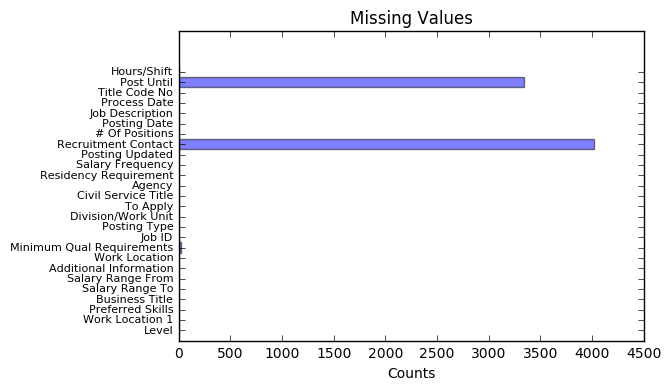

In [3]:
# Check for missing values in any column
observation = len(data)
empty = {}
for col in data:
    tem = len(data[col].dropna())
    empty[col] = observation - tem
barwidth=1
pos = np.arange(len(empty.keys()))
plt.barh(pos+barwidth, empty.values(), barwidth, align='center', alpha=0.5)
plt.yticks(pos+barwidth, empty.keys(), fontsize = 8)
plt.xlabel('Counts')
plt.title('Missing Values')
plt.show()

More that half of the observations have missing values in Recruitment Contact and Post Until. These columns might not be useful.

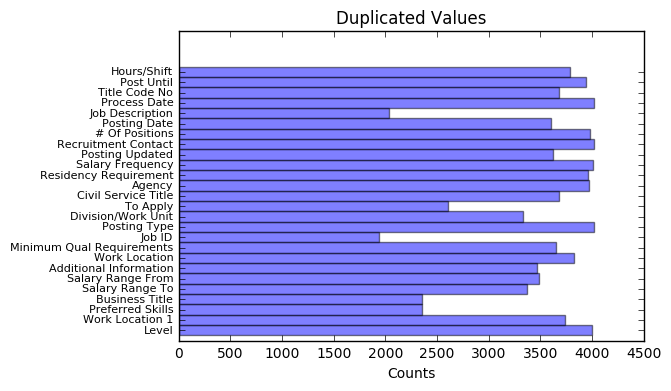

In [4]:
# Check for duplicated values
dup = {}
for col in data:
    tem = data[col].duplicated()
    dup[col] =  tem.sum()
    
barwidth=1
pos = np.arange(len(dup.keys()))
plt.barh(pos+barwidth, dup.values(), barwidth, align='center', alpha=0.5)
plt.yticks(pos+barwidth, dup.keys(), fontsize = 8)
plt.xlabel('Counts')
plt.title('Duplicated Values')
plt.show()

Duplicates are in all columns, even Job ID.

In [5]:
unique_job_id = data['Job ID'].unique()
print ('We have {length2} unique job ids'.format(length2=len(unique_job_id)))

We have 2080 unique job ids


In [6]:
data['Posting Type'].unique()

array(['Internal', 'External'], dtype=object)

Most of the duplicated job ids are due to double posting (Internal and External posting type). Therefore, I will only keep one observation for all observations with the same Job ID and Posting Date

In [7]:
# Drop duplicates that have same Job ID and Posting Date
columns=['Job ID', 'Posting Date']
data_unique = data.drop_duplicates(columns)

We wiil look at number of open positions in each department to find out which one has the most openings, taking into consideration the fact that there are positions with multiple openings.

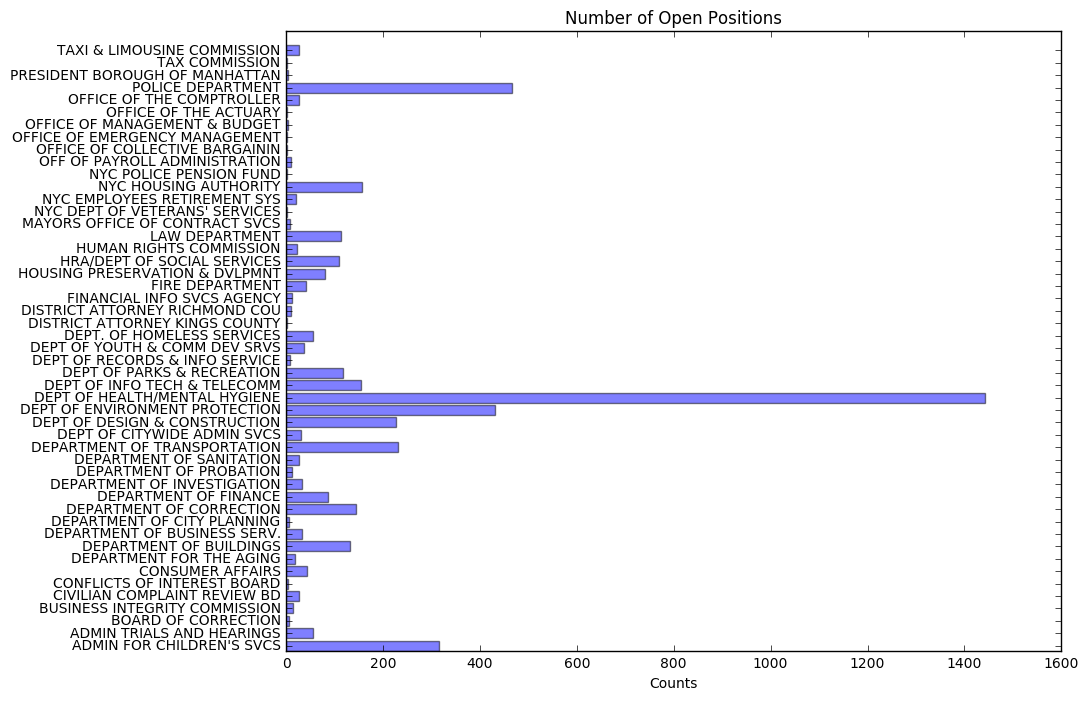

In [8]:
# Group data by Agency and count number of open position
# Sum over # Of Positions columns since there are positions with more than 1 opening
grouped = data_unique.groupby('Agency')
pos_count = grouped.sum()['# Of Positions']
pos = np.arange(len(pos_count))
barwidth=2                    
f, ax = plt.subplots(figsize=(10,8))
rects = ax.barh(pos, pos_count.values, alpha=0.5)
ax.set_yticks(pos+(barwidth/5))
ax.set_yticklabels(pos_count.index)
ax.set_xlabel('Counts')
plt.title('Number of Open Positions')
plt.show()

## The agency that has the most job openings is DEPT OF HEALTH/MENTAL HYGIENE

In [9]:
data_unique['Salary Frequency'].unique()

array(['Annual', 'Hourly', 'Daily'], dtype=object)

Since there are 3 types of salary frequency, I will convert all the salary to annual salary for consistency.

In [10]:
annual_min_sal = []
annual_max_sal = []
for index, row in data_unique.iterrows():
    if row['Salary Frequency'] == 'Annual':
        annual_min_sal.append(row['Salary Range From'])
        annual_max_sal.append(row['Salary Range To'])
    elif row['Salary Frequency'] == 'Hourly':
        annual_min_sal.append(row['Salary Range From']*40*52) 
        annual_max_sal.append(row['Salary Range To']*40*52)
    elif row['Salary Frequency'] == 'Daily':
        annual_min_sal.append(row['Salary Range From']*5*52) 
        annual_max_sal.append(row['Salary Range To']*5*52)
data_unique['Annual Salary Range From'] = annual_min_sal
data_unique['Annual Salary Range To'] = annual_max_sal

C:\Users\Anh\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anh\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Next, we can look at the maximum and minimum salary in each department to find out which department pays the lowest and which pays the highest.

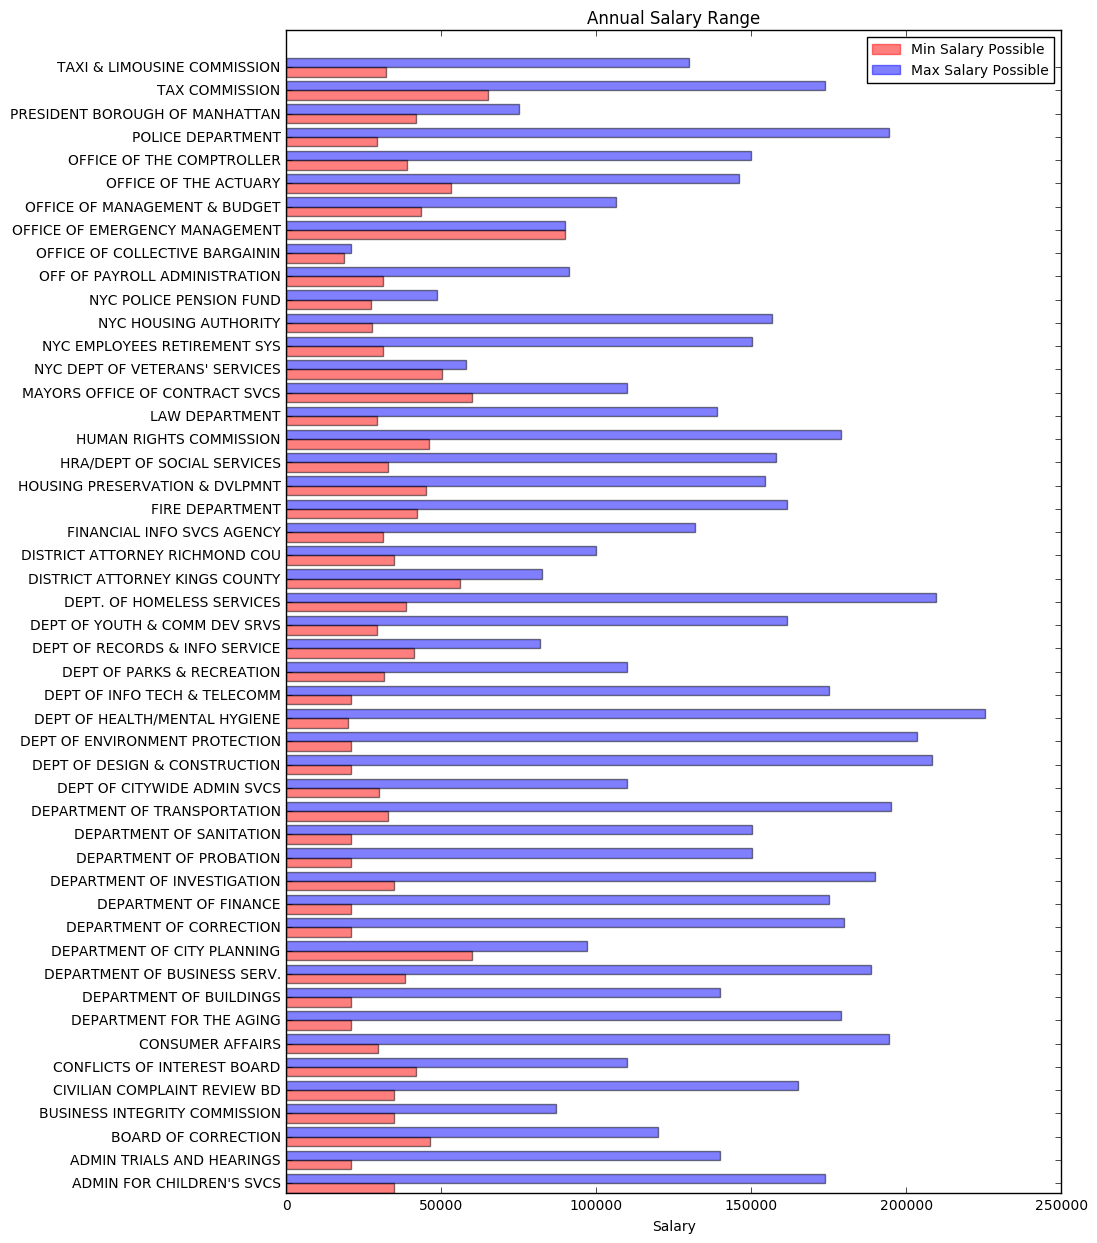

In [11]:
# Look at graph of salary range in each agency
grouped = data_unique.groupby('Agency')
upper_bound = grouped.max()['Annual Salary Range To']
lower_bound = grouped.min()['Annual Salary Range From']

pos = np.arange(len(lower_bound))
barwidth=0.4                   
f, ax = plt.subplots(figsize=(10,15))
rects1 = ax.barh(pos, lower_bound.values, barwidth, alpha=0.5, color = 'r')
rects2 = ax.barh(pos+barwidth, upper_bound.values, barwidth, alpha=0.5, color='b')


ax.set_yticks(pos+(barwidth))
ax.set_yticklabels(lower_bound.index)
ax.set_xlabel('Salary')
plt.title('Annual Salary Range')

red= mpatches.Patch(color='r', alpha=0.5, label='Min Salary Possible')
blue= mpatches.Patch(color='b', alpha=0.5, label='Max Salary Possible')

plt.legend(handles=[red, blue], prop={'size':10})

plt.show()


## Departments with the highest pay

In [12]:
upper_bound.sort_values().tail(5)

Agency
DEPARTMENT OF TRANSPORTATION      195000
DEPT OF ENVIRONMENT PROTECTION    203566
DEPT OF DESIGN & CONSTRUCTION     208298
DEPT. OF HOMELESS SERVICES        209652
DEPT OF HEALTH/MENTAL HYGIENE     225363
Name: Annual Salary Range To, dtype: int64

## Departments with the lowest pay 

In [13]:
lower_bound.sort_values().head(5)

Agency
OFFICE OF COLLECTIVE BARGAININ    18720
DEPT OF HEALTH/MENTAL HYGIENE     19760
DEPARTMENT OF CORRECTION          20800
ADMIN TRIALS AND HEARINGS         20800
DEPT OF ENVIRONMENT PROTECTION    20800
Name: Annual Salary Range From, dtype: int64

Because vairiable Post Until has a lot of missing values, I am not going to analyze that. Instead, I will look at Posting Date and Process Date. I will calculate Process Length = Process Date - Posting Date, in days. 

In [14]:
# create new variable Process_length
post_date_process_date = []
for index, row in data_unique.iterrows():
    try:
        tem = (dateutil.parser.parse(row['Process Date']) - dateutil.parser.parse(row['Posting Date'])).days
        post_date_process_date.append(tem)
    except:
        post_date_process_date.append(None)
data_unique['Process_length'] = post_date_process_date

C:\Users\Anh\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We can look at the box plot of Process_length to see how many days does it take to fill a position, normally.

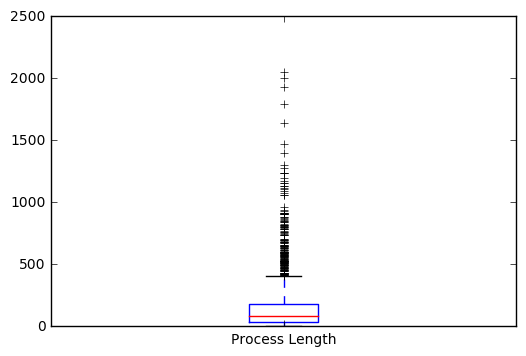

In [15]:
data_to_plot = [data_unique['Process_length']]              
fig = plt.figure(1, figsize=(6, 4))
ax = fig.add_subplot(111)
ax.boxplot(data_to_plot)
ax.set_xticklabels(['Process Length'])
plt.show()

So, positions with Process Length greater than approximatelly 320 days might be outliers.

Next, I look at job levels in the data.

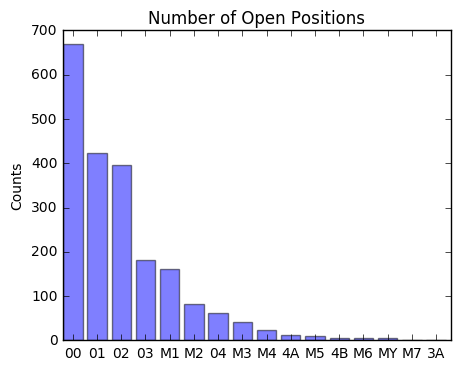

In [16]:
level = data_unique['Level'].value_counts()
pos = np.arange(len(level))
barwidth=2                    
f, ax = plt.subplots(figsize=(5,4))
rects = ax.bar(pos, level.values, alpha=0.5)
ax.set_xticks(pos+(barwidth/5))
ax.set_xticklabels(level.index)
ax.set_ylabel('Counts')
plt.title('Number of Open Positions')
plt.show()

We have a small number of positions at level 3A, M7, M6, MY, 4B, M5, 4A, M4, M3,04, and M2. So I suspect those are senior and executive levels. Hence it is harder to fill.

In [17]:
chosen_level = ['3A','M7','MY','M6','4B','M5','4A','M4','M3','04','M2']

I will box plot variable Annual Salary Range From and Annual Salary Range To to see how maximum and minimum salaries distribute.

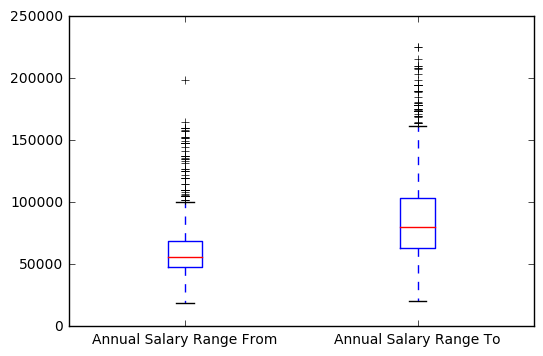

In [18]:
data_to_plot = [data_unique['Annual Salary Range From'], data_unique['Annual Salary Range To']]
fig = plt.figure(1, figsize=(6, 4))
ax = fig.add_subplot(111)
ax.boxplot(data_to_plot)
ax.set_xticklabels(['Annual Salary Range From','Annual Salary Range To'])
plt.show()

In [19]:
display_column = ['Agency','# Of Positions','Business Title','Level',
                  'Process_length', 'Annual Salary Range From','Annual Salary Range To']

## I think jobs that take long to process (greater than about 320 days) and are at levels 3A, M7, M6, MY, 4B, M5, 4A, M4, M3, 04, or M2 are be the hardest job to fill.

In [20]:
hardest = data_unique[(data_unique['Process_length']>320)&
                     data_unique['Level'].isin(chosen_level)][display_column]

## Below are the hardest job to fill, sorted by descending process length, minimum annual salary, and maximum annual salary. 

## If we take into consider job levels, process length, maximum salary, and minimum salary, belows are the hardest job to fill in descending order.

In [21]:
hardest.sort_values(by=['Process_length','Annual Salary Range To','Annual Salary Range From'],ascending=False)

,Agency,# Of Positions,Business Title,Level,Process_length,Annual Salary Range From,Annual Salary Range To
5,DEPARTMENT OF BUSINESS SERV.,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",M3,1790,60740,162014
14,DEPT OF ENVIRONMENT PROTECTION,1,"Director, Strategic Sourcing",M2,1306,90000,120000
37,DEPT OF ENVIRONMENT PROTECTION,1,"Director, Strategic Sourcing",M2,1169,54740,146276
97,DEPT OF ENVIRONMENT PROTECTION,1,"Deputy Commissioner, Engineering Design & Cons...",M7,914,89988,203566
11,NYC EMPLOYEES RETIREMENT SYS,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",04,762,87203,131623
59,NYC HOUSING AUTHORITY,3,ELEVATOR ADMINISTRATOR,M2,739,54740,146276
93,DEPT OF ENVIRONMENT PROTECTION,1,Asset Management Information Specialist,04,698,87203,120754
147,NYC HOUSING AUTHORITY,1,Engineering Audit Officer,M2,644,90000,105000
209,DEPT OF HEALTH/MENTAL HYGIENE,3,"Application Examiner, Office of Vital Records ...",04,592,35284,55390
96,DEPT OF ENVIRONMENT PROTECTION,1,"Deputy Commissioner, Wastewater Treatment",M7,546,198518,198518
